# Day 8 - recursive data structure

Structures containing structures containing ... recursion.

So, I naturally use a stack! Or, like on [day 5](./Day%2005.ipynb), a `deque`.

The stack stores the child and metadata counts as a `[children, meta]` mutable list. You first have to process the children before you can process the metadata for a node, so we need to keep this structure updated until the time to handle the metadata is here. 

Then each time we enter the loop, we check the `children` counter

* If the counter is zero, pop the item from the stack and we can sum `meta` entries from the data stream to the checksum
* otherwise, decrement the counter and add the next two values from the stream to the stack.

In [1]:
from collections import deque
from itertools import islice

def checksum(datastream):
    it = iter(datastream)
    stack = deque([[next(it), next(it)]])
    summed = 0
    while stack:
        if not stack[-1][0]:
            # children done, add the metadata
            _, meta = stack.pop()
            summed += sum(islice(it, None, meta))
        else:
            # decrease counter and process next node
            stack[-1][0] -= 1
            stack.append([next(it), next(it)])
    return summed

In [2]:
testdatastream = [int(d) for d in '''\
2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'''.split()]
assert checksum(testdatastream) == 138

In [3]:
import aocd

data = aocd.get_data(day=8, year=2018)
datastream = [int(d) for d in data.split()]

In [4]:
print('Part 1:', checksum(datastream))

Part 1: 45750


## More stacking about

Now we need to add one more piece of information to our stack entries: a list of child node values, so we can calculate the value for the current completed node. We don't need to keep the whole tree here!

The steps then become:

* Check the `children` counter
* If it is zero, pop the item from the stack. Collect the metadata numbers from the stream, and calculate our value by doing one of two things:
    * If there are no child nodes, sum the metadata numbers.
    * If the list of child nodes is not empty, use the metadata numbers as 1-based indices into the list to sum.

In [5]:
def calc_license(datastream):
    it = iter(datastream)
    stack = deque([[next(it), next(it), []]])
    while True:
        if not stack[-1][0]:
            # children done, calculate value
            _, meta, values = stack.pop()
            if not values:
                value = sum(islice(it, None, meta))
            else:
                # 1-based indexing
                value = sum(
                    values[m - 1] for m in islice(it, None, meta)
                    if 0 < m <= len(values)
                )
            if not stack:
                # last node!
                return value
            stack[-1][-1].append(value)
        else:
            # decrease counter and process next node
            stack[-1][0] -= 1
            stack.append([next(it), next(it), []])

In [6]:
assert calc_license(testdatastream) == 66

In [7]:
print('Part 2:', calc_license(datastream))

Part 2: 23266


## Using recursion

You can use recursion too, of course; the stack is then hidden, in the form of the Python callstack. I'd use an OO approach in that case, where a `Node` class encapsulates the state.

In [8]:
class Node:
    def __init__(self, stream):
        self._stream = iter(stream)
        self._metadata = None
        self._checksum = None
        self._value = None

    def _process_metadata(self):
        if self._metadata is None:
            self._checksum = 0
            self._value = 0
            ccount, mdsize = islice(self._stream, None, 2)
            cvalues = []
            for _ in range(ccount):
                child = type(self)(self._stream)
                self._checksum += child.checksum
                cvalues.append(child.value)
            self._metadata = list(islice(self._stream, None, mdsize))
            mdsum = sum(self._metadata)
            if ccount:
                self._value = sum(cvalues[i - 1] for i in self._metadata if 0 < i <= len(cvalues))
            else:
                self._value = mdsum
            self._checksum += mdsum

    @property
    def checksum(self):
        if self._checksum is None:
            self._process_metadata()
        return self._checksum

    @property
    def value(self):
        if self._value is None:
            self._process_metadata()
        return self._value

In [9]:
root = Node(testdatastream)
assert root.checksum == 138
assert root.value == 66

Using an OO recursion approach does make it easier to augment the process, to generate a graph, say. While you could augment the existing API to pass through additional context information, I'm going to (ab)use the new [`contextvars` module](https://docs.python.org/3/library/contextvars.html#module-contextvars) instead, to track per-subtree contextual state here.

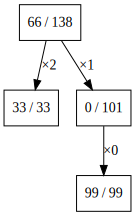

In [10]:
import graphviz
from contextvars import copy_context, ContextVar
from itertools import count

dot = ContextVar('dot')
childids = ContextVar('childids')
idcounter = ContextVar('idcounter')

def _genid():
    return f"node_{next(idcounter.get())}"

class GraphingNode(Node):
    def _process_metadata(self):
        self._id = _genid()
        childids.get([]).append(self._id)

        orig = super()._process_metadata
        def in_context():
            childids.set([])
            orig()

        subtree_ctx = copy_context()
        subtree_ctx.run(in_context)
        d = dot.get()
        d.node(self._id, f"{self.value} / {self.checksum}")
        for i, childid in enumerate(subtree_ctx[childids], 1):
            factor = self._metadata.count(i)
            d.edge(self._id, childid, f"\xD7{factor}")

def plot_license(datastream, edge_attr=None, node_attr=None, **graph_attr):
    digraph = graphviz.Digraph(
        'license_tree',
        graph_attr=graph_attr,
        edge_attr=edge_attr or {},
        node_attr={'shape': 'rectangle', **(node_attr or {})},
    )
    def in_context():
        dot.set(digraph)
        idcounter.set(count())
        GraphingNode(datastream).value
    copy_context().run(in_context)
    return digraph

plot_license(testdatastream)

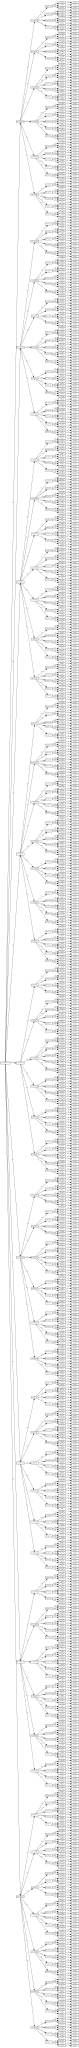

In [11]:
plot_license(
    datastream, 
    rankdir="LR", 
    nodesep="0.03", 
    edge_attr={'fontsize': '10.0'},
    node_attr={'fontsize': '10.0', 'height': '0.15'}
)